In [1]:
from unityagents import UnityEnvironment

import numpy as np
import random
import copy
import sys
from collections import namedtuple, deque

import torch
import torch.nn as nn # neural networks 
import torch.optim as optim
import torch.nn.functional as F


from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

In [2]:
SEED = 1 # replicability randomization seed
np.random.seed(SEED)
torch.random.manual_seed(SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GAMMA = 0.99 #discount factor
ALPHA = 1e-4 #learning rate
CRITIC_ALPHA = 1e-4 #learning rate for the critic
TAU = 0.2 #interpolation parameter

N_AGENTS = 2 # number of agents

MAX_EPISODES = 2000 # max training # max_episodes
MINIBATCH_SIZE = 512 # training batched
BUFFER_SIZE = int(1e6) #replay buffer size

HIDDEN_LAYER_N = [512,256] # hidden layer size
UPDATE_RATE = 4 # update frequency


BENCHMARK = 0.5 # agent goal reward

In [3]:
class ReplayBuffer:
    # fixed size buffer, store experience
    
    
    def __init__(self, action_size, 
                 buffer_size = BUFFER_SIZE, 
                 batch_size = MINIBATCH_SIZE, 
                 seed = SEED):
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", \
            field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
        
    def add(self, state, action, reward, next_state, done):
        # add a new experience to memory
        
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        # randomly sample a batch of experiences from memory
        
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        # return the current size of the memory
        return len(self.memory)
    

In [4]:
class OUNoise(object):
    
    def __init__(self, 
                 n_steps = 10000, 
                 output_dim = 1, 
                 theta = 0.15, 
                 mu = 0., 
                 sigma = 0.3, 
                 x0 = 0, 
                 dt = 1e-2):
        
        self.theta = theta
        self.sigma = sigma
        self.n_steps = n_steps
        self.sigma_step = - self.sigma / float(self.n_steps)
        self.x0 = x0
        self.mu = mu
        self.dt = dt
        self.output_dim = output_dim

    def reset(self):
        self.x0 = 0.0

    def sample(self, step):
        sigma = max(0, self.sigma_step * step \
                        + self.sigma)
        x = self.x0 + self.theta * (self.mu - self.x0) *\
                self.dt + sigma * np.sqrt(self.dt) *\
                np.random.normal(size=self.output_dim)
        self.x0 = x
        
        return x

In [5]:
### Actor Critic

def hidden_init(layer):
    fanction_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fanction_in)
    return (-lim, lim)


class Actor(nn.Module):
    # actor model / maps states -> actions

    def __init__(self, state_size, action_size, 
                 seed = SEED, 
                 hidden_size = HIDDEN_LAYER_N):

        super(Actor, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    # critic model  / (state, action) pairs > q-values

    def __init__(self, state_size, action_size, 
                 seed = SEED, 
                 hidden_size = HIDDEN_LAYER_N):

        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0]+action_size, hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = F.leaky_relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        
        return self.fc3(x)

In [6]:
class Agent:
    # DDPG agent
    def __init__(self,
                    state_size, action_size, 
                    seed = SEED,
                    alpha = ALPHA,
                    critic_alpha = CRITIC_ALPHA,
                    tau = TAU,
                    gamma = GAMMA):
        
        random.seed(seed)
        self.state_size = state_size
        self.action_size = action_size
        
        self.tau = tau
        self.gamma = gamma
        
        # actor network (w/ target )
        self.actor_local = Actor(state_size, action_size, 
                                     seed).to(device)
        self.actor_target = Actor(state_size, action_size, 
                                      seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), 
                                          lr=alpha)

        # critic network (w/ target )
        self.critic_local = Critic(state_size, action_size, 
                                     seed).to(device)
        self.critic_target = Critic(state_size, action_size, 
                                     seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), 
                                           lr=critic_alpha)
        
        # init target networks
        self.soft_update(self.critic_local, self.critic_target, 1.0)
        self.soft_update(self.actor_local, self.actor_target, 1.0)
        
        # init noise process
        self.noise = OUNoise(action_size, seed)
        
    def act(self, state, t_step, add_noise=True):
        # get actions for given state
        
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        
        if add_noise:
            action += self.noise.sample(t_step)
        
        return np.clip(action, -1, 1)
    
    
    def reset(self):
        self.noise.reset()
        
    def learn(self, experiences):
        # update policy via batch learning
        # Q_targets = r + γ * critic_target(next_state, 
        #     actor_target(next_state))
        
        states, actions, rewards, next_states, dones = experiences
        
        ## update critic
        
        # get predicted next-state, actions, and q values from target 
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        
        # calc Q targets for current states
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        
        # calc critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # min the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        ## update actor
        
        # calc actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        
        # min the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        ## update target
        
        self.soft_update(self.critic_local, self.critic_target, \
                         self.tau)
        self.soft_update(self.actor_local, self.actor_target, \
                         self.tau)
        
        return critic_loss.cpu().data.numpy(), \
                        actor_loss.cpu().data.numpy()
    
    def soft_update(self, local_model, target_model, tau):
        # θ_target = τ*θ_local + (1 - τ)*θ_target

        for target_param, local_param in \
                zip(target_model.parameters(), \
                    local_model.parameters()):
            
            target_param.data.copy_(tau*local_param.data +\
                            (1.0-tau)*target_param.data)


        


In [7]:
class MADDPG:
    # multi agent handler 
    
    def __init__(self,
                 state_size, action_size, 
                 n_agents = N_AGENTS,
                 batch_size = MINIBATCH_SIZE,
                 gamma = GAMMA,
                 update_rate = UPDATE_RATE):
        
        self.buffer = ReplayBuffer(action_size)

        self.n_agents = n_agents
        self.agents = [Agent(state_size, action_size) \
                               for _ in range(n_agents)]
        
        self.batch_size = batch_size
        
        self.gamma = gamma
        self.state_size = state_size
        self.action_size = action_size
        self.update_rate = update_rate
        
        self.t_step = 0
        self.loss = (0.0, 0.0)
        
    def reset(self):
        # reset agents
        for agent in self.agents:
            agent.reset()
            
    def act(self, states, add_noise=True):
        # get agent's action
        actions = [agent.act(state, self.t_step, add_noise) \
                   for agent, state in zip(self.agents, states)]
        return actions
    
    def step(self, states, actions, rewards, next_states, dones):
        
        # record experience in buffer
        for state, action, reward, next_state, done in \
        zip(states, actions, rewards, next_states, dones):
            self.buffer.add(state, action, reward, next_state, done)
        
        # learn given update_rate 
        self.t_step += 1
        if self.t_step % self.update_rate == 0:
            if len(self.buffer) > self.batch_size:
                all_critic_loss = []
                all_actor_loss = []
                
                for agent in self.agents:
                    experiences = self.buffer.sample()
                    
                    critic_loss, actor_loss = agent.learn(experiences)
                    all_critic_loss.append(critic_loss)
                    all_actor_loss.append(actor_loss)
                
                self.loss = (np.mean(all_actor_loss), np.mean(all_critic_loss))
                
            
    

In [8]:
#### MAIN ####


env = UnityEnvironment(file_name="Tennis.app")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]


env_info = env.reset(train_mode=True)[brain_name]

action_size = brain.vector_action_space_size
state = env_info.vector_observations
state_size = state.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [9]:
maddpg = MADDPG(state_size, action_size)

In [10]:
scores = []
agents_scores = []
running_avg = []

for i_episode in range(MAX_EPISODES):
    
    maddpg.reset()
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations

    scores_episode = np.zeros(N_AGENTS)

    while True:
        actions = maddpg.act(states)
        env_info = env.step(actions)[brain_name]

        rewards = env_info.rewards
        next_states = env_info.vector_observations
        dones = env_info.local_done
 
        maddpg.step(states, actions, rewards, next_states, dones)

        states = next_states
        scores_episode += rewards
        
        if any(dones):
                break
    
    agents_scores.append(scores_episode)
    scores.append(scores_episode.max())
    running_avg.append(np.mean(scores[-100:]))

            
    if i_episode % 50 == 0:
        print('Episode:',i_episode, \
              '// Episode Score:', round(scores_episode[0],2), 
                                  round(scores_episode[1],2), \
             '// Running Avg: ', round(running_avg[-1],4))
    
    if running_avg[-1].mean() >= BENCHMARK \
            and i_episode >= 100:
        print('Solves at episode: ',i_episode, \
              '// Score: ', running_avg[-1])
        
        torch.save(maddpg.agents[0].actor_local.state_dict(), 'actor.pth')
        torch.save(maddpg.agents[0].critic_local.state_dict(), 'critic.pth')

        break

Episode: 0 // Episode Score: 0.0 -0.01 // Running Avg:  0.0
Episode: 50 // Episode Score: 0.0 -0.01 // Running Avg:  0.0075
Episode: 100 // Episode Score: 0.0 -0.01 // Running Avg:  0.0038
Episode: 150 // Episode Score: 0.0 -0.01 // Running Avg:  0.0
Episode: 200 // Episode Score: -0.01 0.0 // Running Avg:  0.0
Episode: 250 // Episode Score: -0.01 0.0 // Running Avg:  0.0
Episode: 300 // Episode Score: -0.01 0.0 // Running Avg:  0.0
Episode: 350 // Episode Score: 0.0 -0.01 // Running Avg:  0.0
Episode: 400 // Episode Score: -0.01 0.0 // Running Avg:  0.001
Episode: 450 // Episode Score: 0.0 -0.01 // Running Avg:  0.008
Episode: 500 // Episode Score: -0.01 0.0 // Running Avg:  0.0129
Episode: 550 // Episode Score: 0.1 -0.01 // Running Avg:  0.0347
Episode: 600 // Episode Score: -0.01 0.0 // Running Avg:  0.0488
Episode: 650 // Episode Score: 0.0 -0.01 // Running Avg:  0.092
Episode: 700 // Episode Score: 0.0 -0.01 // Running Avg:  0.146
Episode: 750 // Episode Score: 0.0 -0.01 // Runnin

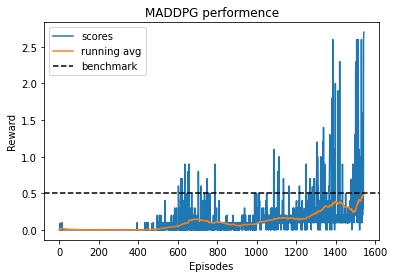

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='scores')
plt.plot(np.arange(len(running_avg)), running_avg, label='running avg')

plt.title('MADDPG performence')
plt.ylabel('Reward')
plt.axhline(y=BENCHMARK, color='black', linestyle="--", label='benchmark')
plt.xlabel('Episodes')
plt.legend()
plt.show()